# Introduction to PyMergence
This notebook serves to introduce the PyMergence library, and illustrate some things you can do with it. PyMergence is a Python library for calculating causal emergence measures from stochastic matrices, which are often used to model systems in physics, biology, and other fields. The central objects in `PyMergence` are stochastic matrices, which represent transition probability matrices (TPMs) that describe the probabilities of transitioning from one state to another in a system. For this, there is a special class called `StochasticMatrix`. Transition probability matrices (TPMs) are represented by object of the `StochasticMatrix` class, which provides methods for various operations on the matrix, such as calculating causal emergence measures, and verifies that the matrix is a valid TPM (i.e., each row sums to 1). 

Section 1 of this notebook show how to calculate the causal primitives of a stochastic matrix. Section 2 then introduces coarse-grainings and macro-level descriptions, based on the `CoarseGraining` class. Section 3 then puts these two together to illustrate how to calculate causal emergence measures. 

The examples are deliberately kept simple, so that you can easily follow the code. For the more complex examples from the CE2.0 paper, see the `recreate_CE2_plots.ipynb` notebook in this repository. 

We start by loading the `StochasticMatrix` class:

In [2]:
from pymergence.StochasticMatrix import StochasticMatrix

The most boring example is the identity matrix, which is a valid Stochastic matrix. If the rows do not sum to 1, an error is raised:

In [3]:
import numpy as np

identity_TPM = StochasticMatrix(np.eye(4))
print("Identity TPM:")
print(identity_TPM)

print("\nIf the rows do not sum to 1, an error is raised:")
try:
    StochasticMatrix(np.array([[1, 0], [0, 2]]))
except ValueError as e:
    print(f"Error: {e}")

Identity TPM:
StochasticMatrix(4x4):
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]

If the rows do not sum to 1, an error is raised:
Error: Each row must sum to 1 (stochastic property)


# 1. Causal Primitives


`StochasticMatrix` objects have methods to immediately calculate various causal primitives. 

Given a stochastic matrix $M$, the sufficiency of a cause $c$ for an effect $e$ is simply the probability of transitioning from state $c$ to state $e$:
$$\text{suff}(c, e) = P(e|do(e)) = M_{ce}$$
The necessity of a cause $c$ for an effect $e$ is 1 minus the probability that the effect $e$ occurs without the cause $c$. For this, we need to introduce a prior probability over causes $P(c)$, to define the necessity as:

$$\text{nec}(c, e) = 1 - \sum_{c' \neq c}M_{c'e}P(c')$$

To characterise $M$ is terms of necessity and sufficiency, it is convenient to define their *averages*:

$$\langle \text{suff} \rangle = \sum_{c, e} P(c, e) \text{suff}(c, e) = \sum_{c,e} P(c) M_{ce}^2$$
$$\langle \text{nec} \rangle = \sum_{c, e} P(c, e) \text{nec}(c, e) = \sum_{c,e} P(c)M_{ce}\text{nec}(c,e)$$

For the identity TPM, the average sufficiency and necessity are maximimal (that is, 1):

In [4]:
print(f"Average sufficiency:\t", identity_TPM.average_sufficiency())
print(f"Average necessity:\t", identity_TPM.average_necessity())

Average sufficiency:	 1.0
Average necessity:	 1.0


By default, when you do not specify a prior intervention distribution, the quantities are calculated under a uniform prior. To see the effect of non-uniform interventions, we define a slightly more complex TPM and a non-uniform intervention distribution. We here weight the fourth cause heavily, and since cause 4 is maximally necessary for effect 4, this weighing increases the average necessity:

In [5]:
example_TPM = StochasticMatrix(np.array([[0.2, 0.7, 0.1, 0.0],
                                         [0.2, 0.7, 0.1, 0.0],
                                         [0.2, 0.6, 0.2, 0.0],
                                         [0.2, 0.4, 0.1, 0.3]]))
intervention_dist = np.array([0.05, 0.02, 0.03, 0.9])

print(f"Average necessity uniform interventions:\t", round(example_TPM.average_necessity(), 2))
print(f"Average necessity under non-uniform interventions:\t", round(example_TPM.average_necessity(intervention_distribution=intervention_dist), 2))

Average necessity uniform interventions:	 0.59
Average necessity under non-uniform interventions:	 0.67


An alternative way to characterize a stochastic matrix is through *determinism* and *degeneracy*. The determinism of a cause $c$ is the entropy of the $c$-th row of the matrix, and the determinism of the matrix is the average determinism of its rows, weighted by the prior probability of the causes:
$$\text{det} = -\sum_c P(c) \sum_e M_{ce} \log_2 (M_{ce})$$

The degeneracy of a stochastic matrix is the inverse of its specificity, where the specificity is the entropy of the marginal distribution over effects:
$$\text{deg} = 1 - \text{spec}$$
$$\text{spec} = - \sum_e \left( \sum_c P(c) M_{ce} \right) \log_2 \left( \sum_c P(c) M_{ce} \right)$$

Throughout this notebook, we calculate entropies in base 2, so that the dimensionless numbers correspond to bits. The identity matrix is maximally deterministic and minimally degenerate, while the example matrix is less deterministic and more degenerate:


In [6]:
print(f"Determinism of identity matrix:\t", round(identity_TPM.determinism(), 2))
print(f"Determinism of example matrix:\t", round(example_TPM.determinism(), 2))
print()
print(f"Degeneracy of identity matrix:\t", round(identity_TPM.degeneracy(), 2))
print(f"Degeneracy of example matrix:\t", round(example_TPM.degeneracy(), 2))

Determinism of identity matrix:	 1.0
Determinism of example matrix:	 0.31

Degeneracy of identity matrix:	 0.0
Degeneracy of example matrix:	 0.22


These quantities, sufficiency, necessity, determinism, and degeneracy/specificity, are referred to as *causal primitives* (CP), as they form the bread and butter of causal emergence analysis. In practice, one is often interested in their respective normalized sums, to there are separate methods for this:

In [7]:
print(f"Suff + Nec of identity matrix:\t", round(identity_TPM.suff_plus_nec(normalize=True), 2))
print(f"Suff + Nec of example matrix:\t", round(example_TPM.suff_plus_nec(normalize=True), 2))
print()
print(f"Det + Spec of identity matrix:\t", round(identity_TPM.effectiveness(), 2))
print(f"Det + Spec of example matrix:\t", round(example_TPM.effectiveness(), 2))

Suff + Nec of identity matrix:	 1.0
Suff + Nec of example matrix:	 0.04

Det + Spec of identity matrix:	 1.0
Det + Spec of example matrix:	 0.09


Indeed, the identity matrix (or any other permutation matrix) maximizes the sums of causal primitives, and noise decreases this. This can be seen by starting with an identity matrix and adding more and more noise to it, keeping track of the sums of the causal primitives:

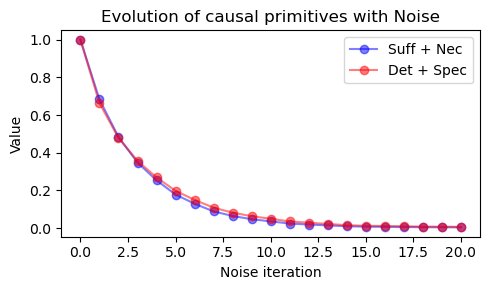

In [8]:
import matplotlib.pyplot as plt

# Start with identity TPM:
noisy_identity_TPM = StochasticMatrix(np.eye(8))

# Keep track of the sums of causal primitives:
det_plus_spec, suff_plus_nec = [], []
det_plus_spec.append(noisy_identity_TPM.effectiveness())
suff_plus_nec.append(noisy_identity_TPM.suff_plus_nec(normalize=True))

for i in range(20):
    # Add random (scaled) noise to the identity TPM:
    noise = np.random.rand(8, 8) * 0.05
    noisy_identity_TPM = noisy_identity_TPM.matrix + noise

    # Ensure the matrix is stochastic:
    noisy_identity_TPM = StochasticMatrix(noisy_identity_TPM / noisy_identity_TPM.sum(axis=1, keepdims=True))
    det_plus_spec.append(noisy_identity_TPM.effectiveness())
    suff_plus_nec.append(noisy_identity_TPM.suff_plus_nec(normalize=True))

# Plot the evolution of the sums of causal primitives:
plt.figure(figsize=(5, 3))
plt.plot(suff_plus_nec, color='blue', marker='o', alpha=0.5, label='Suff + Nec')
plt.plot(det_plus_spec, color='red', marker='o', alpha=0.5, label='Det + Spec')
plt.xlabel('Noise iteration')
plt.ylabel('Value')
plt.title('Evolution of causal primitives with Noise')
plt.legend()
plt.tight_layout()

plt.show()



# 2. Coarse-grainings: from Micro to Macro

To discover causal emergence, you need to calculate the causal primitives at different 'scales', that is, different coarse grainings of a system. To describe these scales, we use the `CoarseGraining` class. This class allows you to define a coarse graining of a stochastic matrix by specifying a mapping from micro states to macro states. The coarse graining can then be applied to a stochastic matrix, and the resulting coarse-grained matrix can be used to calculate causal primitives at the macro scale.

`CoarseGraining` objects can be created from a tuple of tuples that describes the partition of states. For example, the finest graining is the trivial partition where each state is its own macro state:


In [9]:
from pymergence.CoarseGraining import CoarseGraining

finest_partition = CoarseGraining(((0,), (1,), (2,), (3,)))
finest_partition

CoarseGraining(coarse_graining=((0,), (1,), (2,), (3,)), n_blocks=4, block_sizes=[1, 1, 1, 1])

Given a `StochasticMatrix`, this coarse-graining can also be generated directly:

In [10]:
example_TPM = StochasticMatrix(np.array([[1, 0, 0, 0],
                                        [0, 1, 0, 0],
                                        [0, 0, 1/2, 1/2],
                                        [0, 0, 1/2, 1/2]]))

example_TPM.finest_graining()

CoarseGraining(coarse_graining=((0,), (1,), (2,), (3,)), n_blocks=4, block_sizes=[1, 1, 1, 1])

More interesting are the coarse grainings that group states together. For example, we can group the last two states together, which gives us a coarse graining that has three macro states. Note that the `print` function can display `CoarseGraining` objects in a human-readable way:

In [11]:
coarse_graining = CoarseGraining(((0,), (1,), (2, 3)))
print(coarse_graining)

0|1|23



We can then coarse-grain the system by calling the `StochasticMatrix.coarse_grain` method with the coarse graining object:

In [12]:
coarse_grained_TPM = example_TPM.coarse_grain(coarse_graining)
print("original_TPM:", example_TPM)
print()
print("Coarse-grained TPM", coarse_grained_TPM)

original_TPM: StochasticMatrix(4x4):
[[1.  0.  0.  0. ]
 [0.  1.  0.  0. ]
 [0.  0.  0.5 0.5]
 [0.  0.  0.5 0.5]]

Coarse-grained TPM StochasticMatrix(3x3):
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


The above coarse-graining thus makes the system more deterministic---it is now an identity matrix on the macro scale. This is reflected in the causal primitives:

In [13]:
print(f"Determinism before coarse graining:\t", round(example_TPM.determinism(), 2))
print(f"Determinism after coarse graining:\t", round(coarse_grained_TPM.determinism(), 2))

Determinism before coarse graining:	 0.75
Determinism after coarse graining:	 1.0


# 3. Causal Emergence

Of particular interest is how the causal primitives change when we *progressively* coarse-grain a system from the finest microscale to the coarsest macroscale. The degree to which the causal primitives change along this path is referred to as the system's *causal emergence*. The coarsest macroscale is the trivial coarse-graining where all the states are grouped together and the TPM is a single 1 by 1 matrix with the entry 1. We will therefore take the coarse-grainings with two groups (or "blocks") as the coarsest scale of interest. 

The degree of causal emergence therefore depends on the endpoints of the path you choose! Compare, for example, the causal emergence along the path 0|1|2|3 -> 0|13|2 -> 02|13 with the path 0|1|2|3 -> 01|2|3 -> 01|23:

In [14]:
group_01_23 = CoarseGraining(((0,1,), (2, 3)))
group_02_13 = CoarseGraining(((0,2,), (1, 3)))
microscale = example_TPM.finest_graining()

microscale_CP = example_TPM.effectiveness()
causal_emergence_1 = example_TPM.coarse_grain(group_01_23).effectiveness() - microscale_CP
causal_emergence_2 = example_TPM.coarse_grain(group_02_13).effectiveness() - microscale_CP

print(f"Causal emergence along path 0|1|2|3 -> 01|2|3 -> 01|23:\t", round(causal_emergence_1, 2))
print(f"Causal emergence along path 0|1|2|3 -> 0|13|2 -> 02|13:\t", round(causal_emergence_2, 2))

Causal emergence along path 0|1|2|3 -> 01|2|3 -> 01|23:	 0.25
Causal emergence along path 0|1|2|3 -> 0|13|2 -> 02|13:	 -0.56


The causal emergence measure thus indicates that the coarse graining 01|23 is thus 'good' in the sense that it adds effectiveness, whereas the coarse graining 02|13 is 'bad' in the sense that it decreases effectiveness.

That raises the question: how should you choose the path? The CE2.0 paper suggests fixing the macroscale to be the 2-block coarse-graining with the largest CP value. Consider the all possible paths from the microscale to the macroscale. The proposed path is then the longest such path along which the CP values monotonically increase. Given a `StochasticMatrix`, the `PyMergence` package provides `find_single_path()` function in the `core` module that finds this path. 

To use it, we need to calculate the CP values across range of coarse-grainings, for which there is the function `calc_CP_along_CGs()`. By default, it calculates the CP values for all possible coarse-grainings. To find the path, you also need to know how to construct paths in the first place, for which you need to order the coarse-grainings by *refinement* and constructe the so-called "Hasse diagram". The `refinement_graph()` function in the `core` module does this for you, returning a directed graph where the nodes are coarse-grainings and the edges indicate refinement. With this

In [15]:
from pymergence.core import find_single_path, refinement_graph, calc_CP_along_CGs, causal_emergence_single_path, generate_all_coarse_grainings

# Calculate both kinds of CP values for the consistent coarse-grainings
cp_values_eff, all_coarse_grainings = calc_CP_along_CGs(example_TPM, mode='effectiveness')
hasse_diagram = refinement_graph(all_coarse_grainings)

# Find the single path
single_patheff = find_single_path(hasse_diagram, cp_values_eff)
print(f"Chosen path through scales:" , [x[0] for x in single_patheff])

Chosen path through scales: ['0|1|2|3', '0|1|23', '023|1']


Note that while the overall causal emergence is an interesting quantity, it would be nice to apportion it to the individual coarse-grainings. The paper introduces the $\Delta$ CP values, which are just the derivative of the CP values along the path. The function `causal_emergence_single_path()` does all of this in one go: it calculates the optimal path across scales, the CP values along this path, and the $\Delta$ CP values along the path. To see it in action, we first construct a larger system with a clear mesoscale:

In [16]:
tpm = np.array([
    [1.0,    0,  0,  0,    0,    0,  0,  0],  # State 0: Equal chance to go to states 1, 2, 5, 6, or 7
    [0,  1.0,    0,    0,    0,    0,    0,    0],    # State 1: Always transitions to state 0
    [0,  0,    1.0,    0,  0,    0,    0,    0],    # State 2: 50% chance to go to states 3 or 0
    [0,    0,    0,  1.0,    0,  0,    0,    0],    # State 3: 50% chance to go to states 4 or 2
    [0,    0,    0,    0,  1/4,    1/4,    1/4,    1/4],    # State 4: Always transitions to state 3
    [0,    0,    0,    0,  1/4,    1/4,    1/4,    1/4],    # State 5: Always transitions to state 0
    [0,    0,    0,    0,  1/4,    1/4,    1/4,    1/4],    # State 6: Always transitions to state 0
    [0,    0,    0,    0,  1/4,    1/4,    1/4,    1/4],    # State 7: Always transitions to state 0
])

mesoscale_TPM = StochasticMatrix(tpm)


There are over 4000 possible coarse grainings of these 8 states, so it makes sense to filter some out. One way to do this is to only consider coarse grainings that result in stochastic matrices that are "consistent" with the original one. Consistency here puts contraints on the dynamics of random walks on the TPMs (see the paper for details). The `generate_all_coarse_grainings()` function generates all coarse grainings, and the `filter_consistent_CGs()` function filters them to only keep the consistent ones.

In [17]:
all_coarse_grainings = mesoscale_TPM.all_coarse_grainings()
print(f"Number of possible coarse-grainings: {len(all_coarse_grainings)}")

consistent_coarse_grainings = mesoscale_TPM.find_consistent_coarse_grainings()
print(f"Number of consistent coarse-grainings: {len(consistent_coarse_grainings)}")


Number of possible coarse-grainings: 4140
Number of consistent coarse-grainings: 262


We then only consider consistent coarse-grainings in our calculations. From the plots it is clear that the intermediate scale where states 4, 5, 6, and 7 are grouped together maximizes the CP value, and that no further gains can be made at higher levels. 

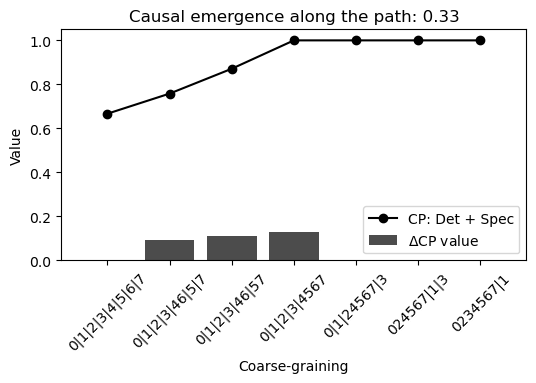

In [18]:
hasse_diagram = refinement_graph(consistent_coarse_grainings)
causal_emergence, path = causal_emergence_single_path(mesoscale_TPM, hasse_diagram, mode='effectiveness')

# Plot the results
partition_labels = [partition_stats[0] for partition_stats in path]
effectiveness_values = [partition_stats[1] for partition_stats in path]
delta_effectiveness_values = [partition_stats[2] for partition_stats in path]

plt.figure(figsize=(6,3))
plt.plot(effectiveness_values, marker='o', label='CP: Det + Spec', color='black')
plt.xticks(range(len(path)), partition_labels, rotation=45)

plt.bar(x = np.arange(len(path)), height = delta_effectiveness_values, color='black', alpha=0.7, label = r'$\Delta$CP value')
plt.xticks(np.arange(len(path)), partition_labels, rotation=45)
plt.xlabel('Coarse-graining')
plt.ylabel('Value')
plt.title(f'Causal emergence along the path: {round(causal_emergence, 2)}')
plt.legend()

plt.show()
